In [9]:
import os
import time
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torchvision import models

class GTSRBDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # print(f"Loaded {len(self.data)} samples from {csv_file}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 7]) # Path is in column 7
        # print(f"Loading image from {img_path}")
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 6] # ClassId is in column 6

        if self.transform:
            image = self.transform(image)

        # print(f"Loaded image: {img_path}, Label: {label}")
        return image, label

# Define the path to the training dataset
train_dir = './data/Train'
test_dir = './data/Test'
model_dir = './model_vgg_transfer'
os.makedirs(model_dir, exist_ok=True)

In [10]:


# Define image size and batch size
image_size = (224, 224)
batch_size = 32
num_epochs = 10
validation_split = 0.2

# Define data augmentation and normalization transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = GTSRBDataset('./data/Train.csv', './data', transform=transform)
test_dataset = GTSRBDataset('./data/Test.csv', './data', transform=transform_eval)

# Print dataset lengths
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Print first few rows of the dataset
# print(train_dataset.data.head())

# Check if the image files exist
for idx in range(5):  # Check first 5 samples
    img_path = os.path.join(train_dataset.root_dir, train_dataset.data.iloc[idx, 7])
    print(f"Checking image path: {img_path}, Exists: {os.path.exists(img_path)}")

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check if DataLoader is empty
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# # Iterate over the train_loader and print labels
# for images, labels in train_loader:
#     print(labels)

Number of training samples: 39209
Number of test samples: 12630
Checking image path: ./data\Train/20/00020_00000_00000.png, Exists: True
Checking image path: ./data\Train/20/00020_00000_00001.png, Exists: True
Checking image path: ./data\Train/20/00020_00000_00002.png, Exists: True
Checking image path: ./data\Train/20/00020_00000_00003.png, Exists: True
Checking image path: ./data\Train/20/00020_00000_00004.png, Exists: True
Number of batches in train_loader: 981
Number of batches in val_loader: 246
Number of batches in test_loader: 395


In [11]:
num_classes = 43

In [6]:
# Define transfer learning model
class TransferLearningVGG(nn.Module):
    def __init__(self, num_classes=43):
        super(TransferLearningVGG, self).__init__()
        
        # Load the pre-trained VGG model
        self.vgg = models.vgg16_bn(pretrained=True)
        
        # Freeze the pre-trained layers
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        # Modify the classifier to match the number of classes
        self.vgg.classifier[6] = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        x = self.vgg(x)
        return F.log_softmax(x, dim=1)

# Initialize the model, loss function, optimizer, and learning rate scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = TransferLearningVGG(num_classes=num_classes).to(device)


device: cuda


c:\Users\easyb\Anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\easyb\Anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\easyb/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [05:50<00:00, 1.58MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [12]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training and validation logs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Save model checkpoint
    torch.save(model.state_dict(), os.path.join(model_dir, f"model_epoch_{epoch+1}.pth"))
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
    
    # Step the learning rate scheduler
    scheduler.step()

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Save loss and accuracy logs for later analysis
np.save(os.path.join(model_dir, "train_losses.npy"), np.array(train_losses))
np.save(os.path.join(model_dir, "val_losses.npy"), np.array(val_losses))
np.save(os.path.join(model_dir, "train_accuracies.npy"), np.array(train_accuracies))
np.save(os.path.join(model_dir, "val_accuracies.npy"), np.array(val_accuracies))

Epoch 1/10 [Validation]: 100%|██████████| 246/246 [01:27<00:00,  2.80it/s]


Epoch 1/10, Train Loss: 1.8548, Train Accuracy: 0.4567, Val Loss: 1.2411, Val Accuracy: 0.6069


Epoch 2/10 [Validation]: 100%|██████████| 246/246 [01:28<00:00,  2.79it/s]


Epoch 2/10, Train Loss: 1.5027, Train Accuracy: 0.5423, Val Loss: 1.1019, Val Accuracy: 0.6451


Epoch 3/10 [Validation]: 100%|██████████| 246/246 [01:29<00:00,  2.76it/s]


Epoch 3/10, Train Loss: 1.4430, Train Accuracy: 0.5629, Val Loss: 0.9964, Val Accuracy: 0.6792


Epoch 4/10 [Validation]: 100%|██████████| 246/246 [01:27<00:00,  2.83it/s]


Epoch 4/10, Train Loss: 1.4125, Train Accuracy: 0.5724, Val Loss: 0.9289, Val Accuracy: 0.6968


Epoch 5/10 [Validation]: 100%|██████████| 246/246 [01:29<00:00,  2.76it/s]


Epoch 5/10, Train Loss: 1.4146, Train Accuracy: 0.5757, Val Loss: 0.9302, Val Accuracy: 0.6890


Epoch 6/10 [Validation]: 100%|██████████| 246/246 [01:28<00:00,  2.77it/s]


Epoch 6/10, Train Loss: 1.2797, Train Accuracy: 0.6043, Val Loss: 0.8376, Val Accuracy: 0.7256


Epoch 7/10 [Validation]: 100%|██████████| 246/246 [01:28<00:00,  2.79it/s]


Epoch 7/10, Train Loss: 1.2425, Train Accuracy: 0.6125, Val Loss: 0.8264, Val Accuracy: 0.7306


Epoch 8/10 [Validation]: 100%|██████████| 246/246 [01:28<00:00,  2.77it/s]


Epoch 8/10, Train Loss: 1.2335, Train Accuracy: 0.6160, Val Loss: 0.8129, Val Accuracy: 0.7344


Epoch 9/10 [Validation]: 100%|██████████| 246/246 [01:28<00:00,  2.79it/s]


Epoch 9/10, Train Loss: 1.2233, Train Accuracy: 0.6169, Val Loss: 0.7959, Val Accuracy: 0.7340


Epoch 10/10 [Validation]: 100%|██████████| 246/246 [01:27<00:00,  2.82it/s]


Epoch 10/10, Train Loss: 1.2087, Train Accuracy: 0.6188, Val Loss: 0.7936, Val Accuracy: 0.7362
Training completed in 4438.00 seconds


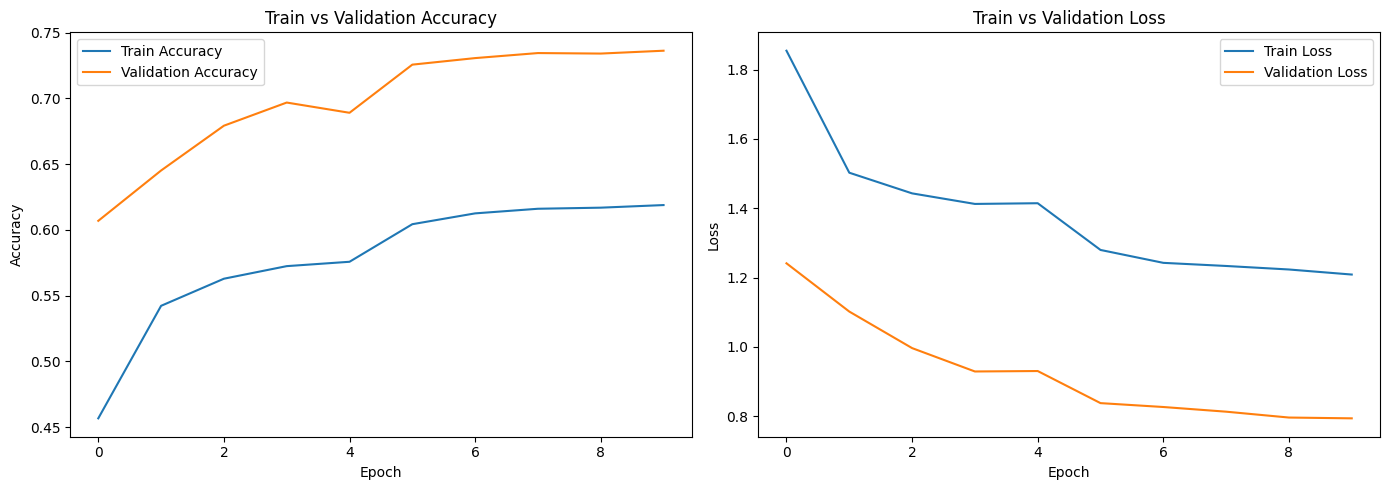

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Load the saved logs
train_losses = np.load(os.path.join(model_dir, "train_losses.npy"))
val_losses = np.load(os.path.join(model_dir, "val_losses.npy"))
train_accuracies = np.load(os.path.join(model_dir, "train_accuracies.npy"))
val_accuracies = np.load(os.path.join(model_dir, "val_accuracies.npy"))

# Plot training vs. validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(train_accuracies, label='Train Accuracy')
ax1.plot(val_accuracies, label='Validation Accuracy')
ax1.set_title('Train vs Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(train_losses, label='Train Loss')
ax2.plot(val_losses, label='Validation Loss')
ax2.set_title('Train vs Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()